In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
# % matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,GradientBoostingClassifier
from sklearn import metrics

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2  
import h5py
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet50 import ResNet50

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
my_arrays_final = np.load("/content/drive/MyDrive/numpy_data_CNN_128*128.npz", allow_pickle=True)


In [4]:
# Extract the X_train, y_train, X_test, and y_test arrays from the data
X_train = my_arrays_final['X_train']
y_train = my_arrays_final['y_train']
X_test = my_arrays_final['X_test']
y_test = my_arrays_final['y_test']

In [5]:
# Print the shapes of the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (6052, 128, 128, 3)
y_train shape: (6052,)
X_test shape: (1514, 128, 128, 3)
y_test shape: (1514,)


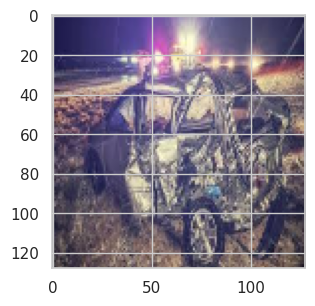

In [6]:
plt.subplot(121)
img = np.reshape(X_train[1], (128,128,3))
plt.imshow(img)

In [6]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(128,128,3))


58889256/58889256 [==============================] - 4s 0us/step


In [7]:
print (base_model.summary())


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [15]:
#Feature extraction using VGG16 as baseline model
featuresTrain= base_model.predict(X_train)

#reshape to flatten feature for Train data
featuresTrain= featuresTrain.reshape(featuresTrain.shape[0], -1)

featuresVal= base_model.predict(X_test)
#reshape to flatten feature for Test data
featuresVal= featuresVal.reshape(featuresVal.shape[0], -1)

48/48 [==============================] - 307s 6s/step


In [16]:
np.save('VGGfeatures_128*128', featuresTrain)


In [17]:
np.save('VGGfeatures_128*128_Val', featuresVal)


In [21]:
model = RandomForestClassifier(400,verbose=1)
model.fit(featuresTrain, y_train)
results_1 = model.predict(featuresTrain)
print (metrics.accuracy_score(results_1, y_train))

# evaluate the model

results = model.predict(featuresVal)
print (metrics.accuracy_score(results, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.0
0.6677675033025099


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished


In [22]:
#Bagging classifier
model23 = BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, 
                            bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False,
                            n_jobs=None, random_state=None, verbose=1)
model23.fit(featuresTrain, y_train)
results_1 = model23.predict(featuresTrain)
print (metrics.accuracy_score(results_1, y_train))


# evaluate the model

results23 = model23.predict(featuresVal)
print (metrics.accuracy_score(results23, y_test))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.0
0.5858652575957728


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


In [9]:
base_model_1 = InceptionV3(include_top=False, weights='imagenet',input_shape=(128,128,3))


In [11]:
#Feature extraction using InceptionV3 as baseline model
featuresTrain_IncepV3= base_model_1.predict(X_train)

#reshape to flatten feature for Train data
featuresTrain_IncepV3= featuresTrain_IncepV3.reshape(featuresTrain_IncepV3.shape[0], -1)


featuresVal_IncepV3= base_model_1.predict(X_test)
#reshape to flatten feature for Test data
featuresVal_IncepV3= featuresVal_IncepV3.reshape(featuresVal_IncepV3.shape[0], -1)


48/48 [==============================] - 58s 1s/step


In [13]:
#Random forest classifier
model2 = RandomForestClassifier(5000,verbose = 1)
model2.fit(featuresTrain_IncepV3, y_train)
results_2 = model2.predict(featuresTrain_IncepV3)
train_accuracy = accuracy_score(y_train, results_2)
print("Training Accuracy:", train_accuracy)


# evaluate the model

results_2 = model2.predict(featuresVal_IncepV3)
test_accuracy = accuracy_score(y_test, results_2)
print("Testing Accuracy:", test_accuracy)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed: 37.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training Accuracy: 1.0
Testing Accuracy: 0.5330250990752973


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    4.8s finished


In [14]:
#Bagging classifier
model44 = BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, 
                            bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False,
                            n_jobs=None, random_state=None, verbose=1)
model44.fit(featuresTrain_IncepV3, y_train)
results44 = model44.predict(featuresTrain_IncepV3)

train_accuracy = accuracy_score(y_train, results44)
print("Training Accuracy:", train_accuracy)

# evaluate the model

results44 = model44.predict(featuresVal_IncepV3)
test_accuracy = accuracy_score(y_test, results44)
print("Testing Accuracy:", test_accuracy)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training Accuracy: 0.9890945142101785
Training Accuracy: 0.47820343461030385


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


In [17]:
#Logistic regression
model3 = LogisticRegression(random_state=0, solver='lbfgs',dual= False,max_iter=1000, multi_class='multinomial',verbose =1).fit(featuresTrain_IncepV3, y_train)

# model3.predict(featuresTrain_IncepV3)
results_3 = model3.predict(featuresTrain_IncepV3)
train_accuracy = accuracy_score(y_train, results_3)
print("Training Accuracy:", train_accuracy)

#evaluate the model

results_3 = model3.predict(featuresVal_IncepV3)
test_accuracy = accuracy_score(y_test, results_3)
print("Testing Accuracy:", test_accuracy)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min finished


Training Accuracy: 1.0
Testing Accuracy: 0.4630118890356671


In [13]:
initialModel = tf.keras.applications.VGG19(weights = 'imagenet',include_top = False, input_shape =(128,128,3))

newModel = tf.keras.Model(inputs = initialModel.input, outputs = initialModel.get_layer('block5_conv2').output)

80134624/80134624 [==============================] - 4s 0us/step


In [14]:
print(newModel.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [15]:
featuresTrain_1= newModel.predict(X_train)

#reshape to flatten feature for Train data
featuresTrain_1= featuresTrain_1.reshape(featuresTrain_1.shape[0], -1)

featuresVal_1= newModel.predict(X_test)
#reshape to flatten feature for Test data
featuresVal_1= featuresVal_1.reshape(featuresVal_1.shape[0], -1)


48/48 [==============================] - 2s 43ms/step


In [18]:
model = RandomForestClassifier(200)
model.fit(featuresTrain_1, y_train)

results = model.predict(featuresTrain_1)
train_accuracy = accuracy_score(y_train, results)
print("Training Accuracy:", train_accuracy)

# evaluate the model

results = model.predict(featuresVal_1)
test_accuracy = accuracy_score(y_test, results)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.6354029062087186


In [22]:
model1 = LogisticRegression(random_state=0, solver='lbfgs',dual= False,max_iter=1000, multi_class='multinomial').fit(featuresTrain_1, y_train)

results_1 = model1.predict(featuresTrain_1)
train_accuracy = accuracy_score(y_train, results_1)
print("Training Accuracy:", train_accuracy)

#evaluate the model

results_1 = model1.predict(featuresVal_1)
test_accuracy = accuracy_score(y_test, results_1)
print("Testing Accuracy:", test_accuracy)



Training Accuracy: 1.0
Testing Accuracy: 0.6968295904887715


In [8]:
NUM_EPOCHS = 50


In [18]:
keep_prob = 0.5
# Load the ImageNet VGG model. Notice we exclude the densely #connected layer at the top
vggModel= tf.keras.applications.VGG16( weights='imagenet', include_top=False, input_shape=(128, 128, 3))

vggModel.trainable= False

model = tf.keras.models.Sequential()
#We now add the vggModel directly to our new model
model.add(vggModel)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 1 - keep_prob))
model.add(tf.keras.layers.Dense(17, activation='softmax'))

print (model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 17)                4369      
                                                                 
Total params: 16,816,465
Trainable params: 2,101,777
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01),metrics=['accuracy'])

H = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
190/190 [==============================] - 21s 59ms/step - loss: 17.4287 - accuracy: 0.3442 - val_loss: 3.7744 - val_accuracy: 0.3415
Epoch 2/50
190/190 [==============================] - 10s 54ms/step - loss: 2.4430 - accuracy: 0.3521 - val_loss: 2.0230 - val_accuracy: 0.4075
Epoch 3/50
190/190 [==============================] - 10s 54ms/step - loss: 1.9511 - accuracy: 0.3762 - val_loss: 1.7154 - val_accuracy: 0.4399
Epoch 4/50
190/190 [==============================] - 10s 50ms/step - loss: 1.7476 - accuracy: 0.3710 - val_loss: 1.6433 - val_accuracy: 0.3758
Epoch 5/50
190/190 [==============================] - 10s 55ms/step - loss: 1.6121 - accuracy: 0.3518 - val_loss: 16.4644 - val_accuracy: 0.3388
Epoch 6/50
190/190 [==============================] - 10s 51ms/step - loss: 1.7743 - accuracy: 0.4053 - val_loss: 1.2936 - val_accuracy: 0.4888
Epoch 7/50
190/190 [==============================] - 10s 51ms/step - loss: 1.3816 - accuracy: 0.4116 - val_loss: 1.2410 - val_accurac

In [11]:
featuresTrain_1= model.predict(X_train)

#reshape to flatten feature for Train data
featuresTrain_1= featuresTrain_1.reshape(featuresTrain_1.shape[0], -1)

featuresVal_1= model.predict(X_test)
#reshape to flatten feature for Test data
featuresVal_1= featuresVal_1.reshape(featuresVal_1.shape[0], -1)


48/48 [==============================] - 2s 40ms/step


In [13]:
np.save('/content/drive/MyDrive/FineTuneVGGfeatures_128*128', featuresTrain_1)


In [14]:
np.save('/content/drive/MyDrive/FineTuneVGGfeatures_128*128', featuresVal_1)

In [15]:
model = RandomForestClassifier(200)
model.fit(featuresTrain_1, y_train)

results = model.predict(featuresTrain_1)
train_accuracy = accuracy_score(y_train, results)
print("Training Accuracy:", train_accuracy)

# evaluate the model

results = model.predict(featuresVal_1)
test_accuracy = accuracy_score(y_test, results)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.8220423000660938
Testing Accuracy: 0.6287978863936592


In [16]:
model1 = LogisticRegression(random_state=0, solver='lbfgs',dual= False,max_iter=1000, multi_class='multinomial').fit(featuresTrain_1, y_train)

results_1 = model1.predict(featuresTrain_1)
train_accuracy = accuracy_score(y_train, results_1)
print("Training Accuracy:", train_accuracy)

#evaluate the model

results_1 = model1.predict(featuresVal_1)
test_accuracy = accuracy_score(y_test, results_1)
print("Testing Accuracy:", test_accuracy)



Training Accuracy: 0.8070059484467944
Testing Accuracy: 0.6301188903566711


In [20]:
# vggModel.trainable = True
# trainableFlag = False

# for layer in vggModel.layers:
#     if layer.name == 'block4_conv1':
#         trainableFlag = True
#     if layer.name == 'block4_conv2':
#         trainableFlag = True
#     if layer.name == 'block4_conv3':
#         trainableFlag = True
#     if layer.name == 'block4_pool':
#         trainableFlag = True
# #    if layer.name == 'block5_conv1':
# #        trainableFlag = True
# #     if layer.name == 'block5_conv2':
# #         trainableFlag = True
# #     if layer.name == 'block5_conv3':
# #         trainableFlag = True
# #     if layer.name == 'block5_pool':
# #         trainableFlag = True
#     layer.trainable = trainableFlag
    
# model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.0001),metrics=['accuracy'])
# #model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),metrics=['accuracy'])
# #model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
#                                # epsilon=None, decay=0.0, amsgrad=Fals,metrics=['accuracy'])
# print (model.summary())
# H2 = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=32, validation_data=(X_test, y_test))
